# Amazon Clothes Recommendation 

## Problem
Given a cloth from the amazon clothes data having many features like title, brand, price, image etc, we will recommend some clothes to the user which he/she might be interesting in buying

### Importing important packages

In [47]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### Loading the data
The data is in json format in the file named amazon_tops_data.json

In [2]:
data = pd.read_json('amazon_tops_data.json')

## Analysing and Understanding the data

In [4]:
print ('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])

Number of data points :  183138
Number of features :  19


In [9]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [6]:
#Names of 19 features
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

### Selecting subset of features
From the given 19 features we will only select the following subset of features to solve the given problem.

1. asin                 :      Amazon standard identification number
2. brand                :      brand of the product
3. title                :      title of the product
4. product_type_name    :      type of the product, ex: SHIRT/TSHIRT 
5. medium_image_url     :      url of the image 
6. color                :      Color information of product, it can contain many colors as a value ex: red and black stripes
7. formatted_price      :      price of the product

In [8]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [11]:
print ('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])

Number of data points :  183138
Number of features :  7


In [10]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


## Analysing every features

### asin

In [12]:
print(data['asin'].describe())

count         183138
unique        183138
top       B0758L7C9W
freq               1
Name: asin, dtype: object


asin is unique number given to every product

### title

In [15]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


### brand

In [16]:
print(data['brand'].describe())

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


count is 182987 while the total products in the data are 183138, therefore there are few products whose brand information is not given.

In [17]:
#For seeing the top 5 brands as per number of products of each brand
brand_count = Counter(list(data['brand']))
brand_count.most_common(5)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193)]

### color

In [18]:
print(data['color'].describe())

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


Again count is 64956 only, therefore there are many products whose color information is not available

In [19]:
#For seeing the top 5 colors as per number of products of each color
color_count = Counter(list(data['color']))
color_count.most_common(5)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289)]

### product_type_name

In [20]:
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [21]:
#For seeing the top 5 product_type_name as per number of products of each product_type_name
color_count = Counter(list(data['product_type_name']))
color_count.most_common(5)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281)]

### formatted_price

In [22]:
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


formatted_price information is not available for many products as the count is only 28395

In [23]:
color_count = Counter(list(data['formatted_price']))
color_count.most_common(5)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472)]

## Removing products with no price or color information

In [29]:
data = data.loc[~data['formatted_price'].isnull()]
data =data.loc[~data['color'].isnull()]

In [30]:
print ('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])

Number of data points :  28385
Number of features :  7


## Removing products with small title length as they will convey only small information

In [32]:
data= data[data['title'].apply(lambda x: len(x.split())>4)]

In [33]:
print ('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])

Number of data points :  27949
Number of features :  7


## Removing duplicate products


###  Removing products with exact same name

In [34]:
print(sum(data.duplicated('title')))

2138


### Removing near duplicates
It has been observed that same products are available in data with 1-2 words change in title.

eg- 

1.A product with different sizes(s,m,l,xl) is present with the almost same title only differing at the end where size is written 

2.Moreover some products name differ only by color and we would not want to recommend same product with just different color
3. Some seller registers same products with small change in title like replacing words like girls with women

a = "women's place is in the house and the senate shirts for Womens XXL White"
b = "women's place is in the house and the senate shirts for Womens M Grey"


We would like to remove all these duplicates for better recommendation

In [39]:
indices = []
for i in range(data.shape[0]):
    indices.append(i)

deduplicated_data = []   #list having deduplicated data

while len(indices)!=0:
    
    i = indices.pop()   # Remove a index from the list of indices
    
    deduplicated_data.append(data['asin'].loc[i])   #Put the product corresponding to the above index in the deduplicated_data
    
    title1 = data['title'].loc[i].split()
  
    for j in indices:
        
        title2 = data['title'].loc[j].split()
        
        max_length = max(len(title1),len(title1))
        
        count  = 0        # count is used to store the number of words that are matched in both the titles

        # itertools.zip_longest(a,b): working
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3, we will remove one of the product
        if (max_length - count) < 3:
            indices.remove(j)


In [38]:
data = data.loc[data['asin'].isin(deduplicated_data)]

In [37]:
print ('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])

Number of data points :  16042
Number of features :  7


### Above code took fairly good amount of time to run, therefore storing the resulting deduplicated data so that it can be used later without running the above code again

In [ ]:
data.to_pickle('pickels/deduplicated_data')

## Text Preprocessing

1.Convert all words to lower case 

2.Remove special characters

3.Remove stop words

In [36]:
data = pd.read_pickle('pickels/deduplicated_data')

In [40]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

list of stop words: {'doesn', 'that', "didn't", 'each', 'itself', 'ourselves', 'then', 'into', 'who', 'here', 'where', 'will', 'herself', 'o', 'had', 'doing', 'to', 'theirs', 'more', "shan't", 'in', 'me', 'until', "won't", 'during', "don't", "weren't", 'too', 'isn', 'is', 'was', 'from', "it's", 'again', 'few', 'she', 'between', 'this', 'we', "mightn't", 'how', 'for', "you've", 'down', 'his', 'my', 'its', 'ain', 'themselves', 'them', 'but', 'a', 'further', 'did', 'most', 'y', "she's", "that'll", 'do', "couldn't", 'needn', 'any', 'out', "needn't", 'now', "haven't", 'with', 'nor', 'having', 'there', 'our', 'be', 'same', 'myself', 'been', 'wasn', 'those', "hasn't", "wouldn't", 'up', 'couldn', 'didn', 'ma', 'does', 'aren', 'hasn', 'just', 'on', "should've", "you'll", 'under', 'yourselves', 'ours', 'hers', 'what', 'are', 'when', 'while', 'mustn', 'him', 'so', 'yours', 'weren', 'mightn', "hadn't", 'once', "wasn't", 'm', 'not', 'or', 'were', 'he', 'off', 'won', 'you', 'hadn', 'such', 'than', '

In [44]:
def text_preprocessing(text, index, column):
    if type(text) is not int:
        string = ""
        for word in text.split():
            
            word = ("".join(e for e in word if e.isalnum()))    # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            
            word = word.lower()                  # Conver all letters to lower-case
            
            if  word not in stop_words:           # stop-word removal
                string += word + " "
        data[column][index] = string

In [45]:
for index, row in data.iterrows():
    text_preprocessing(row['title'], index, 'title')

In [46]:
data.to_pickle('pickels/preprocessed_data')

# Title based product recommendation

In [2]:
data = pd.read_pickle('pickels/preprocessed_data')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


## BOW on titles

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

In [63]:
def bow_model(id, num_recommendations):
   
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[id])
    
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

        url = data['medium_image_url'].loc[df_top_indices[i]]
        
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
       
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()
        
        
        print('ASIN :',data['asin'].loc[df_top_indices[i]])
        print ('Title:', data['title'].loc[df_top_indices[i]])
        print ('Brand:', data['brand'].loc[df_top_indices[i]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)



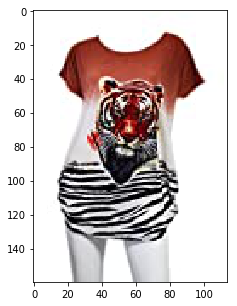

ASIN : B00JXQB5FQ
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.0


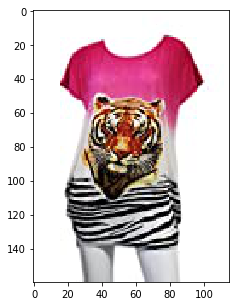

ASIN : B00JXQASS6
Title: pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 1.7320508075688772


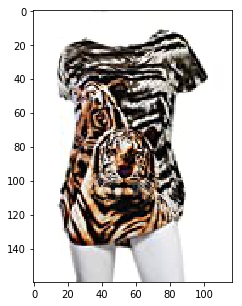

ASIN : B00JXQCWTO
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 2.449489742783178


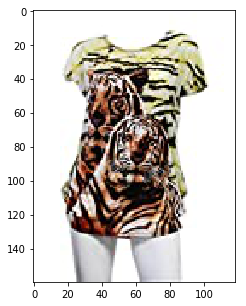

ASIN : B00JXQCUIC
Title: yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 2.6457513110645907


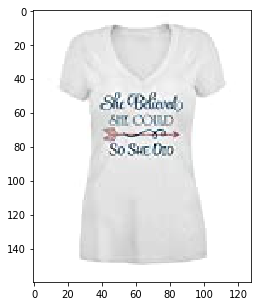

ASIN : B07568NZX4
Title: believed could tshirt 
Brand: Rustic Grace
Euclidean similarity with image : 3.0


In [64]:
bow_model(12566, 5)

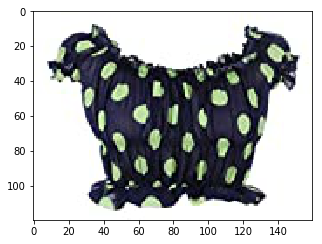

ASIN : B00KLHUIBS
Title: annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Brand: Anna-Kaci
Euclidean similarity with image : 0.0


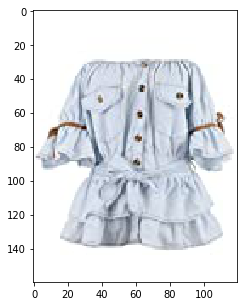

ASIN : B0759G15ZX
Title: annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
Brand: Anna-Kaci
Euclidean similarity with image : 3.3166247903554


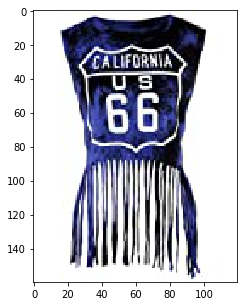

ASIN : B00YQ8S4K0
Title: anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
Brand: Anna-Kaci
Euclidean similarity with image : 3.4641016151377544


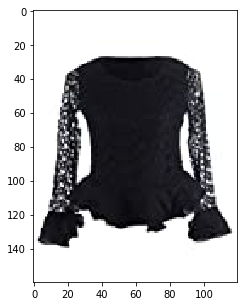

ASIN : B00O194W8W
Title: annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
Brand: Anna-Kaci
Euclidean similarity with image : 3.4641016151377544


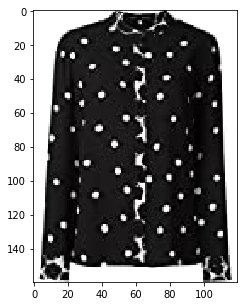

ASIN : B074TLHLMN
Title: proenza schouler black polka dot blouse 2 
Brand: Proenza Schouler
Euclidean similarity with image : 3.4641016151377544


In [65]:
bow_model(931, 5)

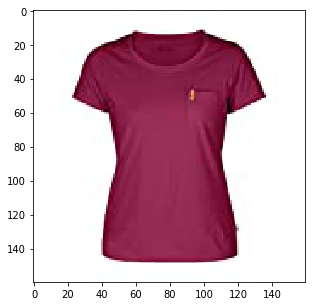

ASIN : B06XC3CZF6
Title: fjallraven  womens ovik tshirt plum xxl 
Brand: Fjallraven
Euclidean similarity with image : 0.0


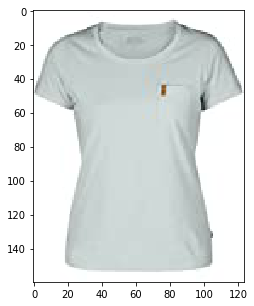

ASIN : B06X19BNJB
Title: fjallraven  womens ovik tshirt ocean mist xs 
Brand: Fjallraven
Euclidean similarity with image : 2.23606797749979


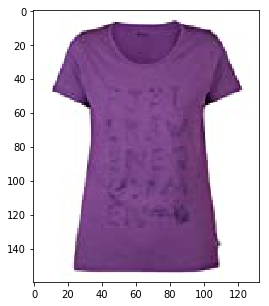

ASIN : B073WKCX36
Title: fjallraven  womens alphabotanical tshirt lily 
Brand: Fjallraven
Euclidean similarity with image : 2.23606797749979


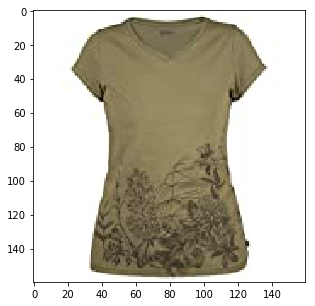

ASIN : B06XDD9XX6
Title: fjallraven  womens meadow tshirt green xxs 
Brand: Fjallraven
Euclidean similarity with image : 2.449489742783178


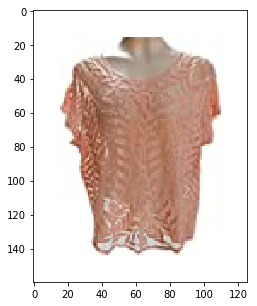

ASIN : B06Y1JPW1Q
Title: xhilaration womens lace tshirt salmon xxl 
Brand: Xhilaration
Euclidean similarity with image : 2.449489742783178


In [66]:
bow_model(31, 5)

## tf-idf Model

In [4]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [68]:
def tfidf_model(id, num_recommendations):
   
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[id])
    
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

        url = data['medium_image_url'].loc[df_top_indices[i]]
        
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
       
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()
        
        
        print('ASIN :',data['asin'].loc[df_top_indices[i]])
        print ('Title:', data['title'].loc[df_top_indices[i]])
        print ('Brand:', data['brand'].loc[df_top_indices[i]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)



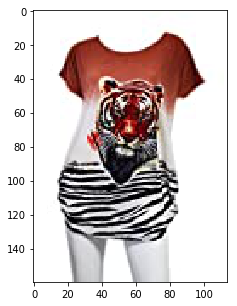

ASIN : B00JXQB5FQ
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.0


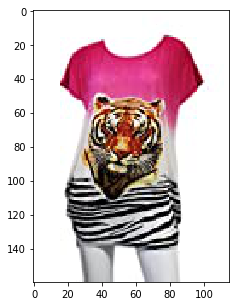

ASIN : B00JXQASS6
Title: pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.7536331912451363


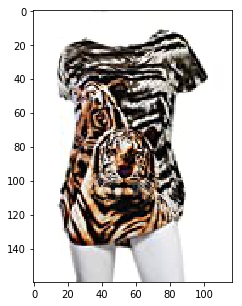

ASIN : B00JXQCWTO
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.9357643943769647


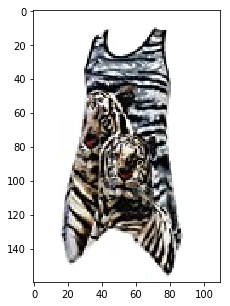

ASIN : B00JXQAFZ2
Title: grey  white tiger tank top tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.9586153524200749


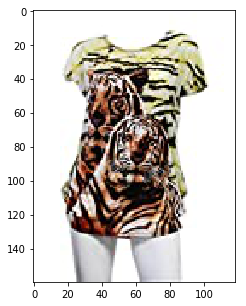

ASIN : B00JXQCUIC
Title: yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 1.000074961446881


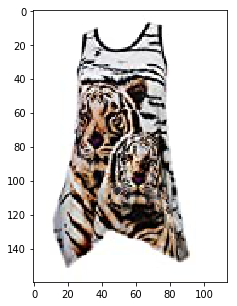

ASIN : B00JXQAO94
Title: black  white tiger tank top tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 1.023215552457452


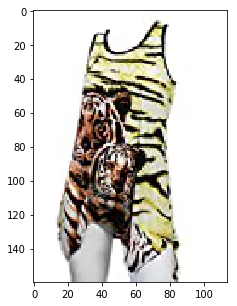

ASIN : B00JXQAUWA
Title: yellow tiger tank top tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 1.031991846303421


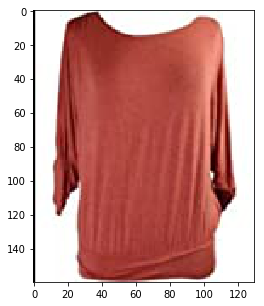

ASIN : B06XSCVFT5
Title: studio womens burnt orange dolman top size medium 
Brand: Studio M
Euclidean similarity with image : 1.2106843670424716


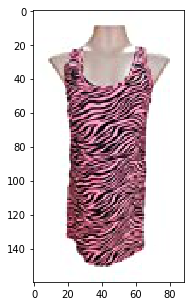

ASIN : B06Y2GTYPM
Title: boundaries juniors racerback ribbed tank pink zebra xxl 
Brand: No Boundaries
Euclidean similarity with image : 1.2121683810720831


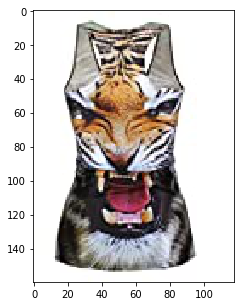

ASIN : B012VQLT6Y
Title: km tiger printed sleeveless vest tshirt 
Brand: KM T-shirt
Euclidean similarity with image : 1.219790640280982


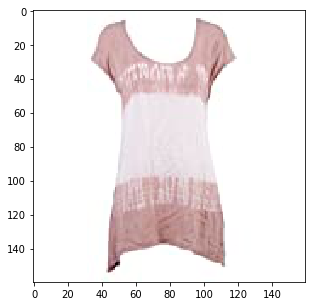

ASIN : B06Y1VN8WQ
Title: black swan estera raw umber l womens shirt 
Brand: Black Swan
Euclidean similarity with image : 1.2206849659998316


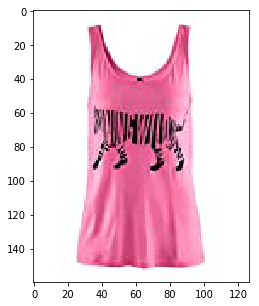

ASIN : B00Z6HEXWI
Title: western zebra pattern sleeveless shirt vest tank tops pink xxl 
Brand: Black Temptation
Euclidean similarity with image : 1.221281392120943


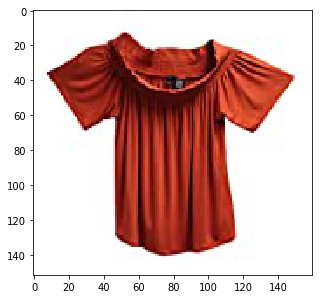

ASIN : B074TR12BH
Title: ultra flirt short sleeve shoulder blouse burnt red xs 
Brand: Ultra Flirt
Euclidean similarity with image : 1.2313364094597743


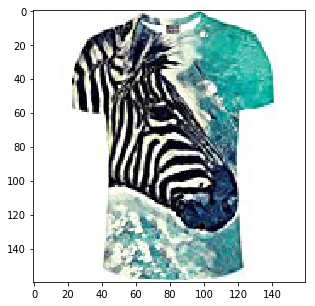

ASIN : B072R2JXKW
Title: womens zebra watercolor tshirt  short sleeve  frontback print  xl 
Brand: WHAT ON EARTH
Euclidean similarity with image : 1.2318451972624516


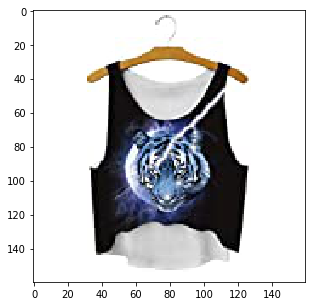

ASIN : B074T8ZYGX
Title: women fashion tiger printed black sleeveless crop top 
Brand: MKP Crop Top
Euclidean similarity with image : 1.2340607457359425


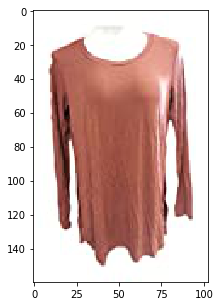

ASIN : B071ZDF6T2
Title: mossimo womens long sleeve side split top burnt orange medium 
Brand: Mossimo
Euclidean similarity with image : 1.2352785577664824


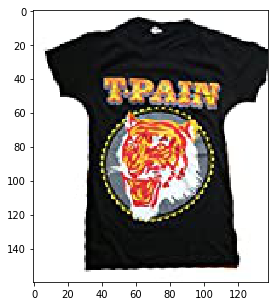

ASIN : B01K0H02OG
Title: tpain tiger juniors tshirt size xlarge 
Brand: Tultex
Euclidean similarity with image : 1.236457298812782


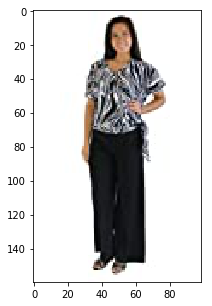

ASIN : B00H8A6ZLI
Title: top  zebra print dolman sleeve top one size 
Brand: Vivian's Fashions
Euclidean similarity with image : 1.24996155052848


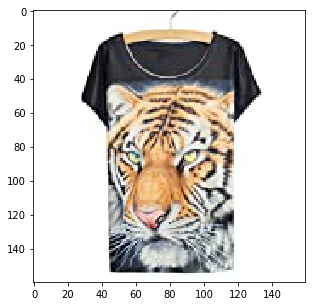

ASIN : B010NN9RXO
Title: yichun womens tiger printed summer tshirts tops 
Brand: YICHUN
Euclidean similarity with image : 1.2535461420856102


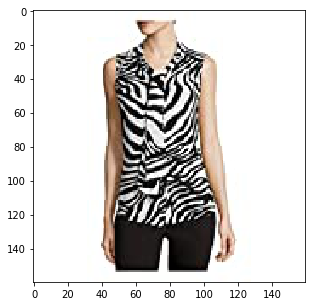

ASIN : B06XBY5QXL
Title: liz claiborne zebra fronttie top size xl 
Brand: Liz Claiborne
Euclidean similarity with image : 1.2538832938357722


In [69]:
tfidf_model(12566, 20)

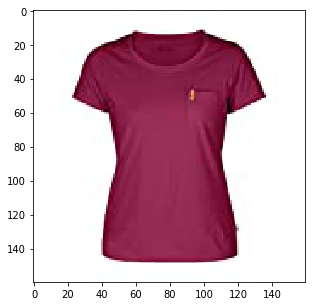

ASIN : B06XC3CZF6
Title: fjallraven  womens ovik tshirt plum xxl 
Brand: Fjallraven
Euclidean similarity with image : 0.0


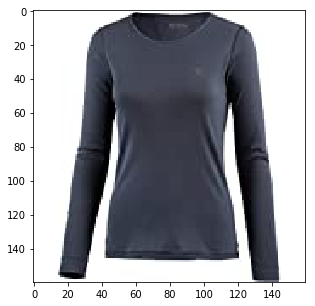

ASIN : B01NBTWIOM
Title: fjallraven  womens ovik longsleeve top navy xs 
Brand: Fjallraven
Euclidean similarity with image : 0.8486756774863707


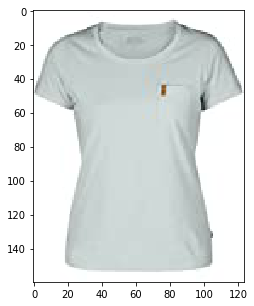

ASIN : B06X19BNJB
Title: fjallraven  womens ovik tshirt ocean mist xs 
Brand: Fjallraven
Euclidean similarity with image : 0.9129339117288455


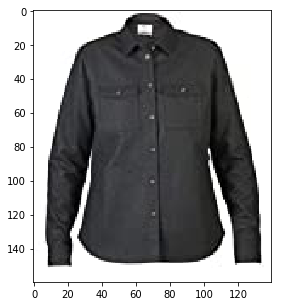

ASIN : B01N7RCYQ4
Title: fjallraven  womens ovik rewool shirt longsleeve dark grey 
Brand: Fjallraven
Euclidean similarity with image : 0.987488005797167


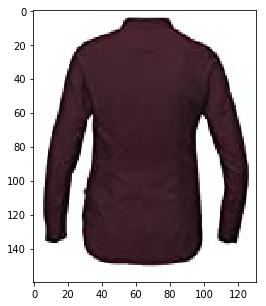

ASIN : B0743MVPJY
Title: fjallraven  womens ovik foxford shirt longsleeve dark garnet xxs 
Brand: Fjallraven
Euclidean similarity with image : 1.0491565623392038


In [70]:
tfidf_model(31,5)

## idf Model 

In [7]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [8]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [9]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [10]:
def idf_model(id, num_recommendations):
   
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[id])
    
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

        url = data['medium_image_url'].loc[df_top_indices[i]]
        
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
       
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()
        
        
        print('ASIN :',data['asin'].loc[df_top_indices[i]])
        print ('Title:', data['title'].loc[df_top_indices[i]])
        print ('Brand:', data['brand'].loc[df_top_indices[i]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)



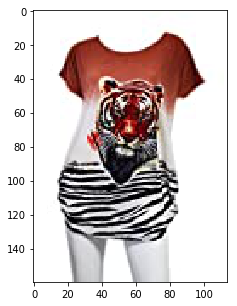

ASIN : B00JXQB5FQ
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.0


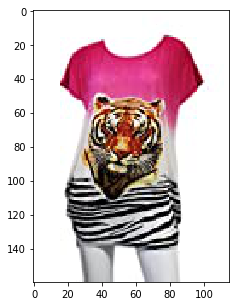

ASIN : B00JXQASS6
Title: pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 12.20507131122177


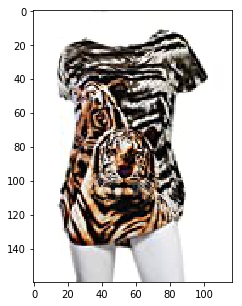

ASIN : B00JXQCWTO
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 14.468362685603465


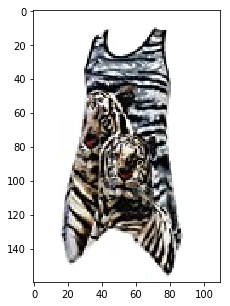

ASIN : B00JXQAFZ2
Title: grey  white tiger tank top tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 14.486832924778964


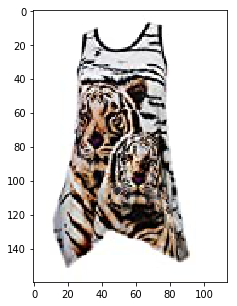

ASIN : B00JXQAO94
Title: black  white tiger tank top tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 14.833392966672909


In [75]:
idf_model(12566,5)

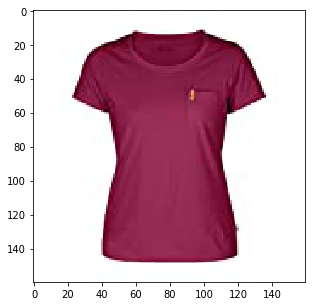

ASIN : B06XC3CZF6
Title: fjallraven  womens ovik tshirt plum xxl 
Brand: Fjallraven
Euclidean similarity with image : 0.0


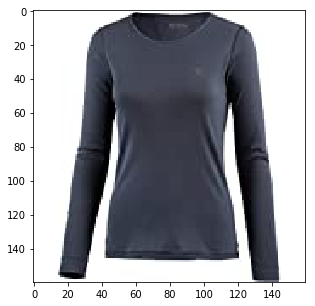

ASIN : B01NBTWIOM
Title: fjallraven  womens ovik longsleeve top navy xs 
Brand: Fjallraven
Euclidean similarity with image : 10.386399214683244


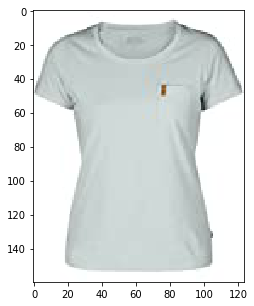

ASIN : B06X19BNJB
Title: fjallraven  womens ovik tshirt ocean mist xs 
Brand: Fjallraven
Euclidean similarity with image : 13.059375759916648


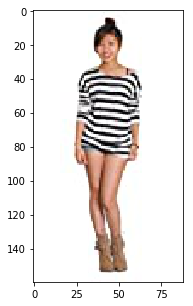

ASIN : B00KF2N5PU
Title: long sleeve top blouse tshirt 
Brand: Vietsbay
Euclidean similarity with image : 13.566442807139692


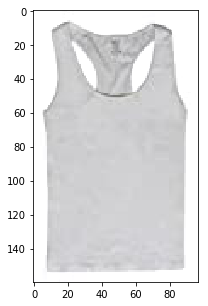

ASIN : B00JPOZ9GM
Title: womens tank top  white 
Brand: Sofra
Euclidean similarity with image : 13.612737930056852


In [78]:
idf_model(31,5)

# Text Semantics based Recommendations

In [5]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [6]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [7]:
# vocab = stores all the words that are there in google w2v model
vocab = model.keys()

In [9]:
def avg_W2V(sentence, num_features, prod_id):
    
    feature_w2v = np.zeros((num_features,), dtype="float32")
    
    n_words = 0
    
    for word in sentence.split():
        n_words += 1
        if word in vocab:
            feature_w2v = np.add(feature_w2v, model[word])
            
    if(n_words>0):
        feature_w2v = np.divide(feature_w2v, n_words)
    
    return feature_w2v

In [10]:
prod_id = 0
w2v_title = []

for i in data['title']:
    w2v_title.append(avg_W2V(i, 300, prod_id))
    prod_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)

In [88]:
def avg_w2v_model(id, num_recommendations):
   
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title,w2v_title[id].reshape(1,-1))
    
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

        url = data['medium_image_url'].loc[df_top_indices[i]]
        
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
       
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()
        
        
        print('ASIN :',data['asin'].loc[df_top_indices[i]])
        print ('Title:', data['title'].loc[df_top_indices[i]])
        print ('Brand:', data['brand'].loc[df_top_indices[i]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)

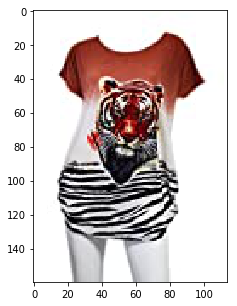

ASIN : B00JXQB5FQ
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.0


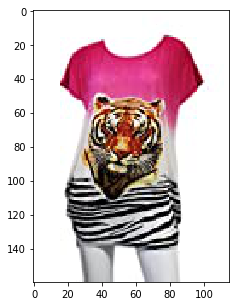

ASIN : B00JXQASS6
Title: pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.5891926


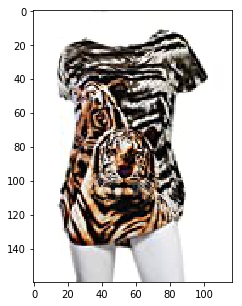

ASIN : B00JXQCWTO
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.7003438


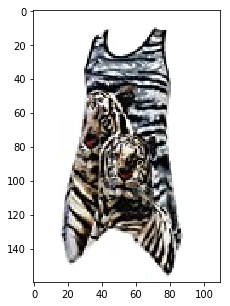

ASIN : B00JXQAFZ2
Title: grey  white tiger tank top tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.89283955


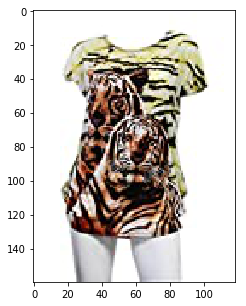

ASIN : B00JXQCUIC
Title: yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 0.95601255


In [89]:
avg_w2v_model(12566, 5)

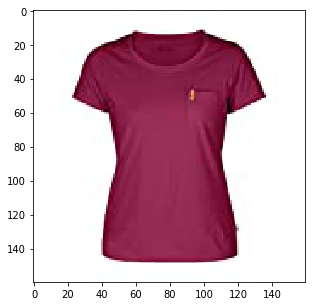

ASIN : B06XC3CZF6
Title: fjallraven  womens ovik tshirt plum xxl 
Brand: Fjallraven
Euclidean similarity with image : 0.0


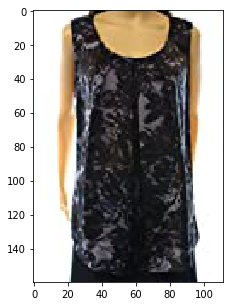

ASIN : B074P94WGR
Title: adrianna papell plum womens abstractprint blouse black xl 
Brand: Adrianna Papell
Euclidean similarity with image : 0.68025964


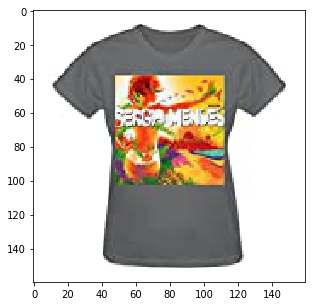

ASIN : B01I6NTX82
Title: sergio mendes encanto women tshirt grey 
Brand: Tony Arden
Euclidean similarity with image : 0.6893834


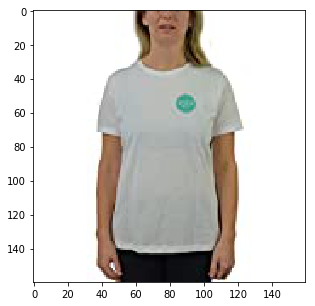

ASIN : B06XQQKGW5
Title: kona dot womens tshirt whiteseafoam szxxl 
Brand: Kona
Euclidean similarity with image : 0.7200141


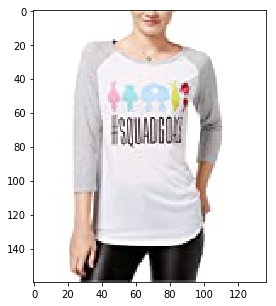

ASIN : B06WLHD6QN
Title: dreamworks womens squadgoals graphic tshirt whitegreyhtr 
Brand: Dreamworks
Euclidean similarity with image : 0.7239287


In [90]:
avg_w2v_model(31, 5)

## idf weighted w2v

In [11]:
def idf_W2V(sentence, num_features, prod_id):
    
    feature_w2v = np.zeros((num_features,), dtype="float32")
    
    n_words = 0
    
    for word in sentence.split():
        n_words += 1
        if word in vocab:
            feature_w2v = np.add(feature_w2v, idf_title_features[prod_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            
    if(n_words>0):
        feature_w2v = np.divide(feature_w2v, n_words)
    
    return feature_w2v

In [12]:
prod_id = 0
idf_w2v_title = []

for i in data['title']:
    idf_w2v_title.append(idf_W2V(i, 300, prod_id))
    prod_id += 1

idf_w2v_title = np.array(idf_w2v_title)

KeyError: 'l'

# weighted similarity using brand and color

In [11]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [18]:
extra_features.shape

(16042, 5735)

In [19]:
color_features.shape

(16042, 1845)

In [22]:
def w2v_extra_features_model(id,w1,w2, num_recommendations):
   
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    w2v_dist = pairwise_distances(w2v_title,w2v_title[id].reshape(1,-1))
    extra_features_dist =  pairwise_distances(extra_features,extra_features[id])
    pairwise_dist= (w1 * w2v_dist +  w2 * extra_features_dist)/float(w1 + w2)
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

        url = data['medium_image_url'].loc[df_top_indices[i]]
        
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
       
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.show()
        
        
        print('ASIN :',data['asin'].loc[df_top_indices[i]])
        print ('Title:', data['title'].loc[df_top_indices[i]])
        print ('Brand:', data['brand'].loc[df_top_indices[i]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)

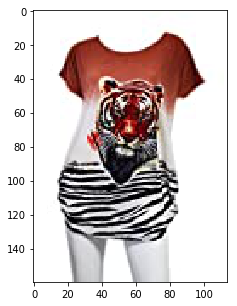

ASIN : B00JXQB5FQ
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.0


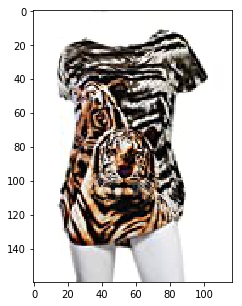

ASIN : B00JXQCWTO
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 0.3501718997955322


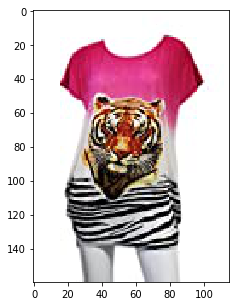

ASIN : B00JXQASS6
Title: pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 1.0017030956167843


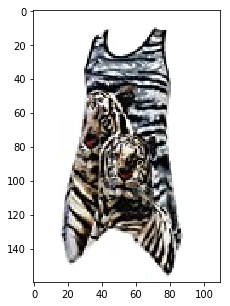

ASIN : B00JXQAFZ2
Title: grey  white tiger tank top tiger stripes xl  xxl 
Brand: Si Row
Euclidean similarity with image : 1.153526544751611


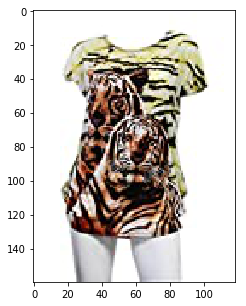

ASIN : B00JXQCUIC
Title: yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Euclidean similarity with image : 1.185113048734155


In [23]:
w2v_extra_features_model(12566,5,5,5)

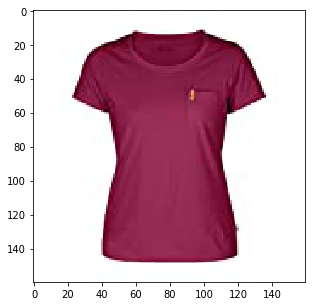

ASIN : B06XC3CZF6
Title: fjallraven  womens ovik tshirt plum xxl 
Brand: Fjallraven
Euclidean similarity with image : 0.0


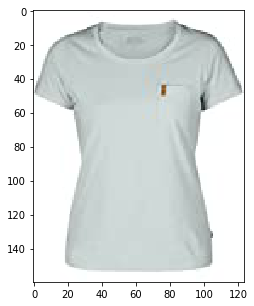

ASIN : B06X19BNJB
Title: fjallraven  womens ovik tshirt ocean mist xs 
Brand: Fjallraven
Euclidean similarity with image : 1.3108964002596584


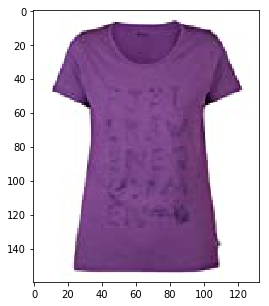

ASIN : B073WKCX36
Title: fjallraven  womens alphabotanical tshirt lily 
Brand: Fjallraven
Euclidean similarity with image : 1.4067817211151123


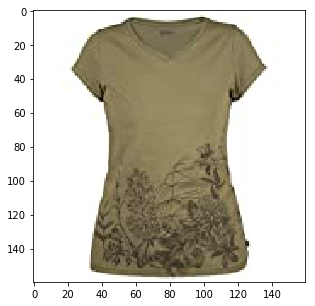

ASIN : B06XDD9XX6
Title: fjallraven  womens meadow tshirt green xxs 
Brand: Fjallraven
Euclidean similarity with image : 1.4151170253753662


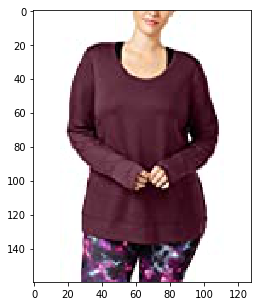

ASIN : B0755LJHPY
Title: ideology womens plus size plum purple open back shirt top 2x 
Brand: Ideology
Euclidean similarity with image : 1.4325461387634277


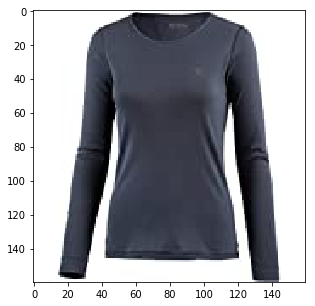

ASIN : B01NBTWIOM
Title: fjallraven  womens ovik longsleeve top navy xs 
Brand: Fjallraven
Euclidean similarity with image : 1.4357541084289551


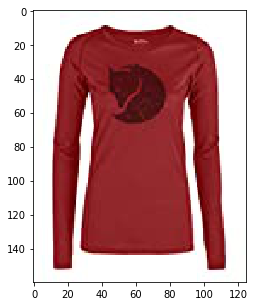

ASIN : B073WLKVN9
Title: fjallraven  womens abisko trail tshirt printed longsleeve lava xxs 
Brand: Fjallraven
Euclidean similarity with image : 1.4373249530792236


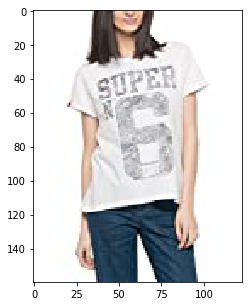

ASIN : B01N1ZGDTC
Title: superdry womens 6 entry womens white tshirt size white 
Brand: Superdry
Euclidean similarity with image : 1.462897777557373


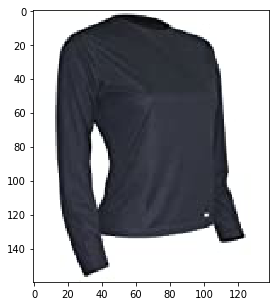

ASIN : B000V5DK7E
Title: polarmax womens tech silk ls crew 2015 black xsmall 
Brand: Polarmax
Euclidean similarity with image : 1.4800321102142333


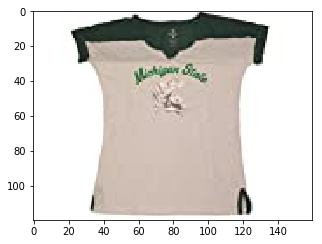

ASIN : B073FM6QD2
Title: michigan state spartans colosseum womens glitter logo scoop neck tshirt 
Brand: Colosseum
Euclidean similarity with image : 1.4853954315185547


In [49]:
w2v_extra_features_model(31,5,5,10)

# Image based product similarity

In [25]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


In [51]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [52]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


In [57]:
def cnn_model(id, num_recommendations):
   
    doc_id = asins.index(df_asins[id])
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(bottleneck_features_train,bottleneck_features_train[id].reshape(1,-1))
    
    # np.argsort will return indices of the smallest distances
    top_indices = np.argsort(pairwise_dist.flatten())[0:num_recommendations]
    
    
    #pdists will store the smallest distances
    samllest_dists  = np.sort(pairwise_dist.flatten())[0:num_recommendations]

    #corresponding data frame indices to the top_indices
    df_top_indices = list(data.index[top_indices])
    
    for i in range(0,len(top_indices)):

#         url = data['medium_image_url'].loc[data['asin']==asins[top_indices[i]]]
        
#         response = requests.get(url)
#         img = Image.open(BytesIO(response.content))
       
#         fig = plt.figure(figsize=(5,5))
#         plt.imshow(img)
#         plt.show()
        
        
        print('ASIN :',data['asin'].loc[data['asin']==asins[top_indices[i]]])
        print ('Title:', data['title'].loc[data['asin']==asins[top_indices[i]]])
        print ('Brand:', data['brand'].loc[data['asin']==asins[top_indices[i]]])
        print ('Euclidean similarity with image :', samllest_dists[i])
        print('='*100)

In [54]:
#get similar products using CNN features (VGG-16)
def get_re_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

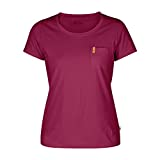

Product Title:  fjallraven  womens ovik tshirt plum xxl 
Euclidean Distance from input image: 5.560829e-06
Amazon Url: www.amzon.com/dp/B06XC3CZF6


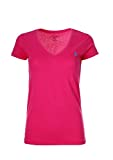

Product Title:  polo ralph lauren womens pony logo vneck tee xsmall shocking pink 
Euclidean Distance from input image: 28.705141
Amazon Url: www.amzon.com/dp/B01JDKEZPS


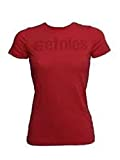

Product Title:  etnies tonal lockup red womans tshirt new regular red medium 
Euclidean Distance from input image: 28.84221
Amazon Url: www.amzon.com/dp/B072TR6LKW


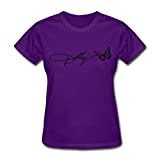

Product Title:  dolly parton logo woman comfy purple 
Euclidean Distance from input image: 29.16135
Amazon Url: www.amzon.com/dp/B01EL6978E


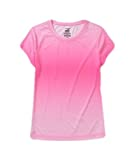

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 29.173353
Amazon Url: www.amzon.com/dp/B01F7PHXY8


In [59]:
get_re_cnn(31, 5)

In [58]:
cnn_model(31, 5)

ASIN : 78280    B000TZP25O
Name: asin, dtype: object
Title: 78280    ultraclub ladies classic wrinklefree longsleev...
Name: title, dtype: object
Brand: 78280    UltraClub
Name: brand, dtype: object
Euclidean similarity with image : 7.0080464e-06
ASIN : 86261    B0038MPIKE
Name: asin, dtype: object
Title: 86261    ultraclub womens classic wrinklefree long slee...
Name: title, dtype: object
Brand: 86261    UltraClub
Name: brand, dtype: object
Euclidean similarity with image : 22.436934
ASIN : 180002    B003QOK94O
Name: asin, dtype: object
Title: 180002    ultraclub ladies classic wrinklefree longsleev...
Name: title, dtype: object
Brand: 180002    UltraClub
Name: brand, dtype: object
Euclidean similarity with image : 31.231146
ASIN : 182876    B0038MPIB8
Name: asin, dtype: object
Title: 182876    ultraclub womens classic wrinklefree oxford sh...
Name: title, dtype: object
Brand: 182876    UltraClub
Name: brand, dtype: object
Euclidean similarity with image : 31.995918
ASIN : 142973    B

# Recommendation based on all features

In [62]:
#get similar products using CNN features (VGG-16)
def get_recommendation_all(doc_id,w1,w2,w3, num_results):
    doc_id = asins.index(df_asins[doc_id])
    
    cnn_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    w2v_dist = pairwise_distances(w2v_title,w2v_title[doc_id].reshape(1,-1))
    extra_features_dist =  pairwise_distances(extra_features,extra_features[doc_id])
    pairwise_dist= (w1 * w2v_dist +  w2 * extra_features_dist + w3*cnn_dist)/float(w1 + w2+ w3)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

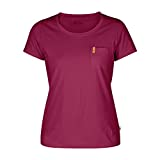

Product Title:  fjallraven  womens ovik tshirt plum xxl 
Euclidean Distance from input image: 1.8536096225337435e-06
Amazon Url: www.amzon.com/dp/B06XC3CZF6


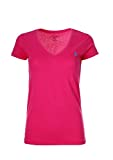

Product Title:  polo ralph lauren womens pony logo vneck tee xsmall shocking pink 
Euclidean Distance from input image: 10.874308014156933
Amazon Url: www.amzon.com/dp/B01JDKEZPS


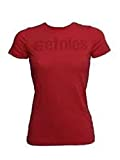

Product Title:  etnies tonal lockup red womans tshirt new regular red medium 
Euclidean Distance from input image: 11.039381268752008
Amazon Url: www.amzon.com/dp/B072TR6LKW


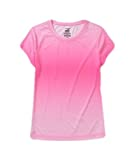

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 11.076401964823406
Amazon Url: www.amzon.com/dp/B01F7PHXY8


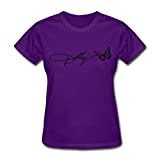

Product Title:  dolly parton logo woman comfy purple 
Euclidean Distance from input image: 11.1216734568278
Amazon Url: www.amzon.com/dp/B01EL6978E


In [63]:
get_recommendation_all(31,5,5,5,5)

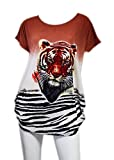

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 2.108653279719874e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


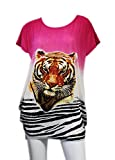

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 11.27987200419108
Amazon Url: www.amzon.com/dp/B00JXQASS6


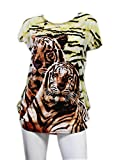

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 14.990159647226609
Amazon Url: www.amzon.com/dp/B00JXQCUIC


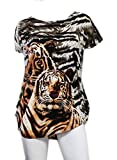

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 15.922306101084029
Amazon Url: www.amzon.com/dp/B00JXQCWTO


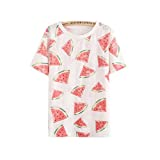

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 16.9517360051473
Amazon Url: www.amzon.com/dp/B01JUNHBRM


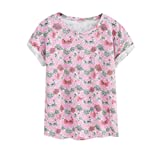

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 17.01277374482182
Amazon Url: www.amzon.com/dp/B071FCWD97


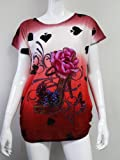

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 17.0925168355306
Amazon Url: www.amzon.com/dp/B00JV63QQE


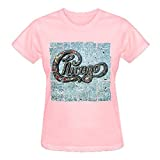

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 17.123817698160806
Amazon Url: www.amzon.com/dp/B01GXAZTRY


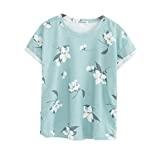

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 17.135717492286307
Amazon Url: www.amzon.com/dp/B071SBCY9W


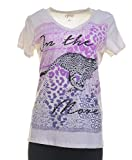

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 17.191070943061455
Amazon Url: www.amzon.com/dp/B01CUPYBM0


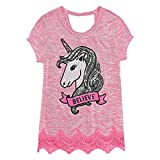

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 17.22670455186482
Amazon Url: www.amzon.com/dp/B0177DM70S


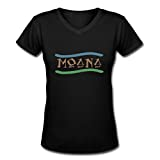

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 17.26194904852823
Amazon Url: www.amzon.com/dp/B01LX6H43D


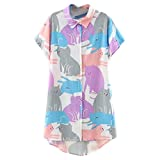

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 17.28430101284301
Amazon Url: www.amzon.com/dp/B01CR57YY0


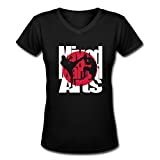

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 17.29298274217441
Amazon Url: www.amzon.com/dp/B01JQ096HW


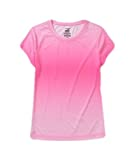

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 17.301070158243455
Amazon Url: www.amzon.com/dp/B01F7PHXY8


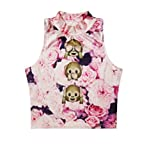

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 17.3126987188895
Amazon Url: www.amzon.com/dp/B015H3W9BM


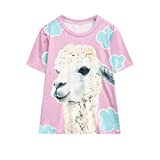

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 17.33326620316533
Amazon Url: www.amzon.com/dp/B01I80A93G


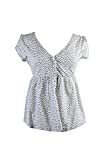

Product Title:  denim  supply ralph lauren womens floral print scalloped blouse multi 
Euclidean Distance from input image: 17.334929691186694
Amazon Url: www.amzon.com/dp/B06XG3CP9S


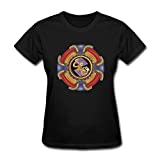

Product Title:  dasy womens neck electric light orchestra logo shirt xxlarge black 
Euclidean Distance from input image: 17.355003234728123
Amazon Url: www.amzon.com/dp/B016EXUZC4


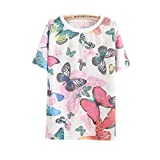

Product Title:  cute pastel tops tees colorful butterfly design print size 
Euclidean Distance from input image: 17.368683690260994
Amazon Url: www.amzon.com/dp/B019E3TD10


In [64]:
get_recommendation_all(12566,5,5,5,20)